In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras import datasets, layers, models
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import cv2


2024-03-30 08:41:59.306221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/hanafahim/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = os.path.abspath('veggie_heap_training')
test = os.path.abspath('veggie_heap_testing')


val_ds = tf.keras.utils.image_dataset_from_directory(
  data,
  validation_split=0.2,
  subset="validation",
  labels='inferred',
  seed=42,
  image_size=(256, 256),
  batch_size=32,
  shuffle=True
  )
train_ds = tf.keras.utils.image_dataset_from_directory(
  data, 
  validation_split=0.2,
  subset='training',
  labels='inferred',
  seed=42,
  image_size=(256, 256),
  batch_size=32,
  shuffle=True
  )
test_ds=tf.keras.utils.image_dataset_from_directory(
  test, 
  labels='inferred',
  seed=42,
  image_size=(256, 256),
  batch_size=32,
  shuffle=True
  )

Found 9835 files belonging to 12 classes.
Using 1967 files for validation.
Found 9835 files belonging to 12 classes.
Using 7868 files for training.
Found 2424 files belonging to 12 classes.


performing data augmentation 

In [3]:
def apply_augmentation(image):
    if np.random.rand() < 0.25:  # Apply blur with 25% probability
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0) 
        return blurred_image
    else:
        return image  

def rgb_to_gray_random(image):
    if np.random.rand() < 0.5:  # Convert to grayscale with 50% probability
        gray_image = tf.image.rgb_to_grayscale(image)
        return gray_image
    else:
        return image  

In [4]:
train_datagen = ImageDataGenerator(

    preprocessing_function=lambda img: rgb_to_gray_random(apply_augmentation(img)),
    rotation_range=45,      
    shear_range=0.2,        
    zoom_range=0.4,   
    brightness_range=(0.5,1.5),      
    fill_mode='reflect',
    validation_split=0.2    )
test_datagen=ImageDataGenerator(
    rotation_range=0
)

In [5]:
train_generator = train_datagen.flow_from_directory(
        directory=os.path.abspath('veggie_heap_training'),
        target_size=(256, 256),  
        batch_size=32,
        subset='training',
        seed=42,
        shuffle=True,
        class_mode='categorical') 
valid_generator=train_datagen.flow_from_directory(
    directory=os.path.abspath('veggie_heap_training'),
    subset='validation',
    target_size=(256, 256), 
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical'
)
test_generator=test_datagen.flow_from_directory(
    directory=os.path.abspath('veggie_heap_testing'),
    class_mode='categorical',
    seed=42,
    shuffle=True,


)

Found 7872 images belonging to 12 classes.
Found 1963 images belonging to 12 classes.
Found 2424 images belonging to 12 classes.


In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
INPUT_SHAPE = (256, 256, 3)  

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', strides=1,input_shape=INPUT_SHAPE,kernel_regularizer = l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='same', strides=1,kernel_regularizer = l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='same', strides=1,kernel_regularizer = l2(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))



model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(12))
model.add(BatchNormalization()) 
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [ ]:
print(type(train_generator))

<class 'keras.src.preprocessing.image.DirectoryIterator'>


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks_list=[checkpoint]


In [17]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

history = model.fit_generator(train_generator, epochs=20,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_generator,callbacks=callbacks_list)
model.save('model.h5')

/var/folders/hq/31k7qhxj16315fvc4cc2j2b00000gn/T/ipykernel_4646/3168076924.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=20,steps_per_epoch=STEP_SIZE_TRAIN,validation_data=valid_generator,callbacks=callbacks_list)


Epoch 1/20
246/246 [==============================] - 276s 1s/step - loss: 1.7285 - accuracy: 0.5057 - val_loss: 1.3690 - val_accuracy: 0.6006
Epoch 2/20
246/246 [==============================] - 226s 918ms/step - loss: 1.3572 - accuracy: 0.6340 - val_loss: 1.2836 - val_accuracy: 0.6368
Epoch 3/20
246/246 [==============================] - 232s 942ms/step - loss: 1.1815 - accuracy: 0.6884 - val_loss: 1.1590 - val_accuracy: 0.7112
Epoch 4/20
246/246 [==============================] - 224s 909ms/step - loss: 1.0746 - accuracy: 0.7096 - val_loss: 0.9475 - val_accuracy: 0.7310
Epoch 5/20
246/246 [==============================] - 217s 882ms/step - loss: 0.9785 - accuracy: 0.7367 - val_loss: 0.9375 - val_accuracy: 0.7723
Epoch 6/20
246/246 [==============================] - 227s 924ms/step - loss: 0.9202 - accuracy: 0.7494 - val_loss: 0.8465 - val_accuracy: 0.7830
Epoch 7/20
246/246 [==============================] - 286s 1s/step - loss: 0.8697 - accuracy: 0.7637 - val_loss: 0.7588 - val_a

/Users/hanafahim/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
loss, accuracy = model.evaluate(test_generator)

76/76 [==============================] - 14s 177ms/step - loss: 1.0325 - accuracy: 0.7149


1/1 [==============================] - 0s 258ms/step


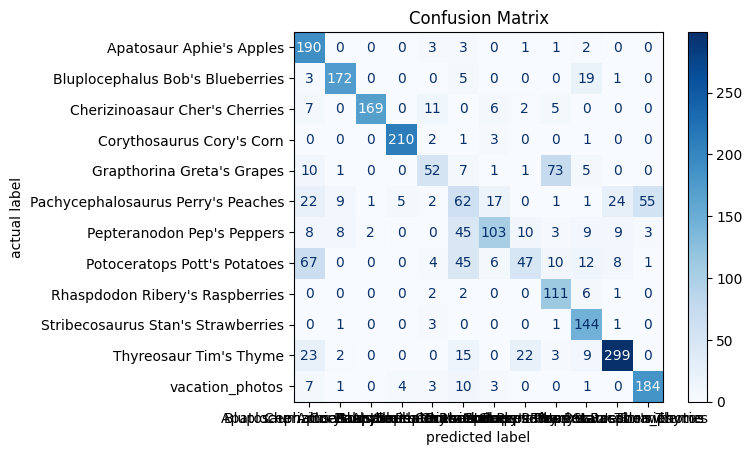

In [19]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred=np.array([])
y_true=np.array([])
for x,y in test_ds:
    y_pred_onehot =model.predict(x)
    y_p = np.argmax(y_pred_onehot, axis=1)
    y_pred=np.concatenate([y_pred,y_p])

    y_true=np.concatenate([y_true,y])


cm = confusion_matrix(y_true, y_pred)
labels = train_ds.class_names  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('predicted label')
plt.ylabel('actual label')
plt.show()